In [107]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

In [126]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
#df.info()

In [127]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [128]:
def get_family_size(x):
    family_size = x['SibSp']+x['Parch']
    return family_size

df['Family_size'] = df.apply(get_family_size, axis=1)
test_df['Family_size'] = df.apply(get_family_size, axis=1)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1


In [129]:
df.at[61, "Embarked"] = "C" #Since name is french assign cherbourgh
df.at[829, "Embarked"] = "S" #The name here count be from either Ireland or England so 
                            #S is assigned since it is vastly more common
    
#for test data we will simply assign S
test_df['Embarked'].fillna('S', inplace=True)

In [130]:
df['Fare'].fillna(np.mean(df['Fare']), inplace=True)
test_df['Fare'].fillna(np.mean(df['Fare']), inplace=True)

In [131]:
df['Cabin'].fillna(value = 'unknown', inplace=True)
test_df['Cabin'].fillna(value='unknown', inplace=True)

def cabin(cab, letters):
    for letter in letters:
        if letter in cab:
            return letter
    return None

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

df['Cabin'] = df['Cabin'].map(lambda x: cabin(x, letters))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: cabin(x, letters))

In [132]:
def title(name, titles):
    for title in titles:
        if title in name:
            return title
    return None

title_list = ['Mrs', 'Mr', 'Miss', 'Master']

df['Title'] = df['Name'].map(lambda x: title(x, title_list))
test_df['Title'] = test_df['Name'].map(lambda x: title(x, title_list))

def impute_Nones(x):
    if pd.isnull(x['Title']):
        if x['Sex'] == 'male':
            if x['Age'] <= 12:
                return 'Master'
            else:
                return 'Mr'
        elif x['Sex'] == 'female':
            if x['Age'] >= 23:
                return 'Mrs'
            else:
                return 'Miss'
    else:
        return x['Title']

df['Title'] = df.apply(impute_Nones, axis=1)
test_df['Title'] = df.apply(impute_Nones, axis=1)


df['Title'].value_counts()

Mr        537
Miss      180
Mrs       134
Master     40
Name: Title, dtype: int64

mrs_mean_age: 35.47008547008547
mr_mean_age: 32.98441247002398
miss_mean_age: 21.77777777777778
master_mean_age: 4.574166666666667


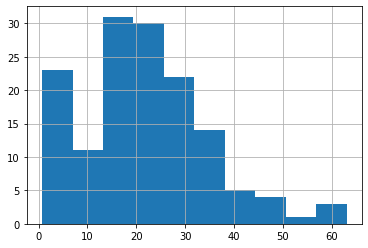

In [133]:
mrs = df.loc[df['Title'] == 'Mrs']
mrs_mean_age = np.mean(mrs['Age'])

mr = df.loc[df['Title'] == 'Mr']
mr_mean_age = np.mean(mr['Age'])

miss = df.loc[df['Title'] == 'Miss']
miss_mean_age = np.mean(miss['Age'])

master = df.loc[df['Title'] == 'Master']
master_mean_age = np.mean(master['Age'])

print('mrs_mean_age:', mrs_mean_age)
print('mr_mean_age:', mr_mean_age)
print('miss_mean_age:', miss_mean_age)
print('master_mean_age:', master_mean_age)
miss['Age'].hist()

In [134]:
def impute_ages(x):
    if pd.isnull(x['Age']):
        if x['Title'] == 'Mrs':
            return 35
        elif x['Title'] == 'Master':
            return 4.5
        elif x['Title'] == 'Miss':
            return 22
        else:
            return 33
    else:
        return x['Age']

df['Age'] = df.apply(impute_ages, axis=1)
test_df['Age'] = df.apply(impute_ages, axis=1)

In [135]:
#df = pd.get_dummies(df, columns = ['Title', 'Embarked', 'Cabin'])
#test_df = pd.get_dummies(test_df, columns = ['Title', 'Embarked', 'Cabin'])
df = pd.get_dummies(df, columns = ['Embarked', 'Cabin'])
test_df = pd.get_dummies(test_df, columns = ['Embarked', 'Cabin'])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,1,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,1,0,0,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,1,0,0,0,0,0,0,0


In [136]:
encoder = preprocessing.LabelEncoder()

features = ['Sex']
for feature in features:
    df[feature] = encoder.fit_transform(df[feature])
    test_df[feature] = encoder.fit_transform(test_df[feature])

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Family_size,...,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,892,3,"Kelly, Mr. James",1,22.0,0,0,330911,7.8292,1,...,0,1,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,38.0,1,0,363272,7.0000,1,...,0,0,1,0,0,0,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,26.0,0,0,240276,9.6875,0,...,0,1,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",1,35.0,0,0,315154,8.6625,1,...,0,0,1,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,35.0,1,1,3101298,12.2875,0,...,0,0,1,0,0,0,0,0,0,0


In [144]:
#make test and train data
y = df['Survived']
X = df.drop(['Survived', 'PassengerId', 'Ticket', 'Name', 'Title'], axis=1)

X_submission = test_df.drop(['PassengerId', 'Ticket', 'Name', 'Title'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Family_size,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,3,1,22.0,1,0,7.2500,1,0,0,1,0,0,0,0,0,0,0
1,1,0,38.0,1,0,71.2833,1,1,0,0,0,0,1,0,0,0,0
2,3,0,26.0,0,0,7.9250,0,0,0,1,0,0,0,0,0,0,0
3,1,0,35.0,1,0,53.1000,1,0,0,1,0,0,1,0,0,0,0
4,3,1,35.0,0,0,8.0500,0,0,0,1,0,0,0,0,0,0,0


In [145]:
grid_size = 5
n_estimators = (np.linspace(10,200,grid_size,dtype=int))
learning_rates = np.logspace(start=-2, stop=1,num=grid_size)
max_depth = np.arange(1,3)
parameters = {'n_estimators':n_estimators,'max_depth':max_depth, 'learning_rate':learning_rates}

grid = GridSearchCV(GradientBoostingClassifier(random_state=0), parameters, refit=True, cv=5)
clf = grid.fit(x_train,y_train)
grid.best_params_

{'learning_rate': 0.05623413251903491, 'max_depth': 2, 'n_estimators': 200}

In [146]:
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=2, random_state=0)
gb_clf = gb_clf.fit(X, y)
print('cross_val_score: ', np.mean(cross_val_score(gb_clf, X, y, cv=5)))


cross_val_score:  0.8294331805913


In [58]:
lr_clf = LogisticRegression(max_iter=1000).fit(x_train, y_train)
lr_clf.score(x_test, y_test)
print('cross_val_score: ', np.mean(cross_val_score(lr_clf, X, y, cv=5)))

cross_val_score:  0.7889962965287804


In [142]:
rf_clf = RandomForestClassifier(n_estimators = 200, max_depth=3, random_state=0).fit(X, y)
print('cross_val_score: ', np.mean(cross_val_score(rf_clf, X, y, cv=5)))

cross_val_score:  0.8013997865796247


GradientBoost Metrics
Accuracy Score: 0.7653631284916201
F1 Score: 0.6818181818181819
roc_auc_score: 0.743188184364655


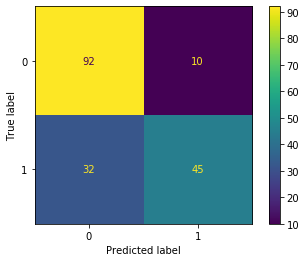

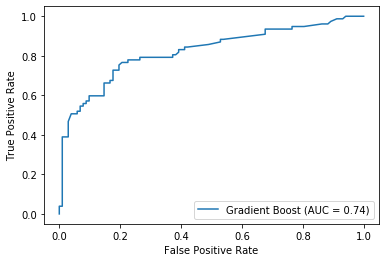

In [81]:
def evaluate_model(model, x_test, y_test, estimator_name):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()
    print('Accuracy Score:', accuracy_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('roc_auc_score:', roc_auc_score(y_test, y_pred, average='weighted'))
    ypp = model.predict_proba(x_test)
    fpr, tpr, th = roc_curve(y_test, ypp[:,1], pos_label=clf.classes_[1])
    roc_auc = roc_auc_score(y_test, y_pred, average='weighted')
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=estimator_name).plot()

print('GradientBoost Metrics')
estimator_name = 'Gradient Boost'                                 
evaluate_model(clf, x_test, y_test, estimator_name)

Logistic Regression Metrics
Accuracy Score: 0.8100558659217877
F1 Score: 0.7500000000000001
roc_auc_score: 0.7927112949082451


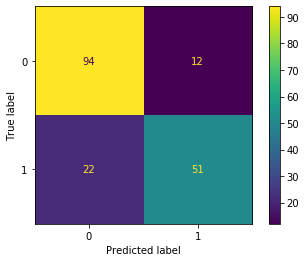

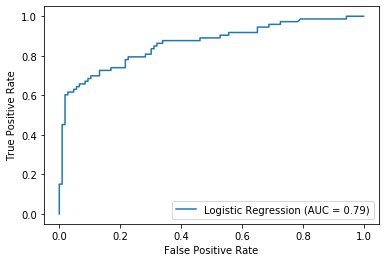

In [60]:
print('Logistic Regression Metrics')
estimator_name = 'Logistic Regression'
evaluate_model(clf1, x_test, y_test, estimator_name)

In [147]:
submission_predictions = gb_clf.predict(X_submission)
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':submission_predictions})
submission.to_csv('submission.csv', index=False)

In [42]:
submission_test = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':submission_predictions, 'Name':test_df['Name']})
submission_test.to_csv('sub_test.csv', index=False)